In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import matplotlib.pyplot as plt

DATA_FILES = {
    "pushup": "pushup.txt",
    "squat": "squat.txt"
}
# Gán nhãn: pushup = 1, squat = 0

LABEL_MAPPING = {
    "pushup": 1,
    "squat": 0
}
NO_OF_TIMESTEPS = 10 
MODEL_SAVE_PATH = "pushup_squat_lstm_model.h5"

X_data = []
y_data = []

print("Loading and preparing data...")
for action_name, filename in DATA_FILES.items():
    file_path = filename 
    if not os.path.exists(file_path):
        print(f"Warning: Data file '{file_path}' for action '{action_name}' not found. Skipping.")
        continue

    print(f"  Processing {action_name} data from {file_path}...")
    try:
        df = pd.read_csv(file_path, header=None)
        dataset = df.values  
    except pd.errors.EmptyDataError:
        print(f"  Warning: File {file_path} is empty. Skipping.")
        continue
    except Exception as e:
        print(f"  Error reading {file_path}: {e}. Skipping.")
        continue

    n_samples = len(dataset)
    if n_samples < NO_OF_TIMESTEPS:
        print(f"  Warning: Not enough data for {action_name} ({n_samples} frames) to create sequences of length {NO_OF_TIMESTEPS}. Skipping.")
        continue

    for i in range(NO_OF_TIMESTEPS, n_samples):
        X_data.append(dataset[i - NO_OF_TIMESTEPS:i, :]) 
        y_data.append(LABEL_MAPPING[action_name])
    print(f"  Added {n_samples - NO_OF_TIMESTEPS + 1} sequences for {action_name}.")


if not X_data:
    print("No data was loaded. Cannot train the model. Please check your data files.")
    exit()

X = np.array(X_data)
y = np.array(y_data)

print(f"\nTotal X shape: {X.shape}") 
print(f"Total y shape: {y.shape}")
print(X[0].shape)
print(y[0])

if X.shape[2] == 0:
    print("Error: Number of features is 0. Check your data files and make_data script.")
    exit()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Loading and preparing data...
  Processing pushup data from pushup.txt...
  Added 2705 sequences for pushup.
  Processing squat data from squat.txt...
  Added 1847 sequences for squat.

Total X shape: (4550, 10, 132)
Total y shape: (4550,)
(10, 132)
1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            36600     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

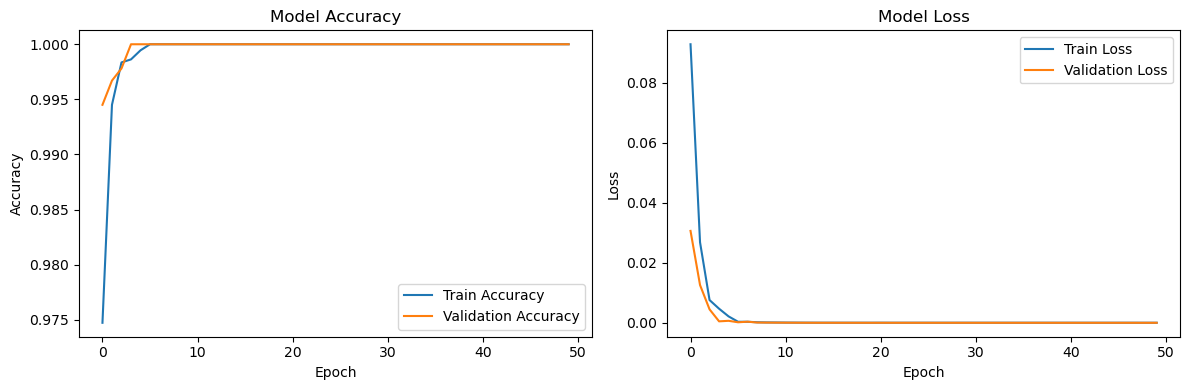

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50)) 
model.add(Dropout(0.2))
model.add(Dense(units=1, activation="sigmoid")) 

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

model.summary() 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# --- Train Model ---
print("\nTraining model...")
history = model.fit(
    X_train,
    y_train,
    epochs=50,  
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr] 
)

# --- Evaluate Model ---
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- Save Model ---
model.save(MODEL_SAVE_PATH)
print(f"\nModel saved to {MODEL_SAVE_PATH}")



plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("training_history.png")
print("Training history plot saved to training_history.png")
plt.show() 